In [1]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#loading dataset
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
x_train.shape

(50000, 32, 32, 3)

In [6]:
x_test.shape

(10000, 32, 32, 3)

In [36]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

**Normalizing images**

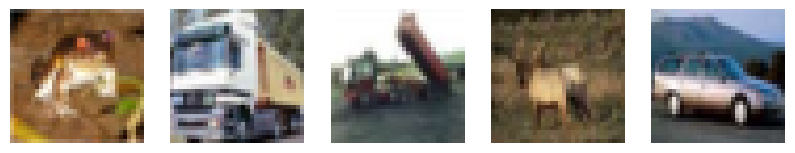

In [19]:
# Function to display a few images
def display_images(images, labels=None, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        if labels is not None:
            plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()

# Assuming x_train is your normalized numpy array of shape (10000, 32, 32, 3)
# and y_train are the corresponding labels (optional)
display_images(x_train, labels=None, num_images=5)


In [50]:
import tensorflow as tf

def normalize(images):
  return images / 255.0

train_dataset =  normalize(x_train)
test_dataset  =  normalize(x_test)

# Converting the numpy arrays to TensorFlow datasets and pair with labels
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Cache, shuffle, batch, and prefetch the datasets
BATCH_SIZE = 64
num_train_examples = len(x_train)
num_test_examples = len(x_test)

train_dataset = train_dataset.cache().shuffle(num_train_examples).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [45]:
# Defining a CNN using TensorFlow's Keras API
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [47]:
# Defining an optimizer, loss function, and metrics for evaluation
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [52]:
# Fit the model on the training data and validate it on the test data for 10 epochs
model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
782/782 [==============================] - 4s 5ms/step - loss: 0.6054 - sparse_categorical_accuracy: 0.7875 - val_loss: 1.0823 - val_sparse_categorical_accuracy: 0.6623
Epoch 2/20
782/782 [==============================] - 4s 5ms/step - loss: 0.5741 - sparse_categorical_accuracy: 0.7982 - val_loss: 1.0502 - val_sparse_categorical_accuracy: 0.6799
Epoch 3/20
782/782 [==============================] - 4s 6ms/step - loss: 0.5224 - sparse_categorical_accuracy: 0.8162 - val_loss: 1.1905 - val_sparse_categorical_accuracy: 0.6583
Epoch 4/20
782/782 [==============================] - 4s 4ms/step - loss: 0.4971 - sparse_categorical_accuracy: 0.8251 - val_loss: 1.2730 - val_sparse_categorical_accuracy: 0.6613
Epoch 5/20
782/782 [==============================] - 4s 4ms/step - loss: 0.4778 - sparse_categorical_accuracy: 0.8321 - val_loss: 1.3153 - val_sparse_categorical_accuracy: 0.6504
Epoch 6/20
782/782 [==============================] - 5s 6ms/step - loss: 0.4383 - sparse_categorica

**Evaluating the model**

In [53]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/64))
print('Accuracy on test dataset:', test_accuracy)

157/157 [==============================] - 0s 3ms/step - loss: 1.9804 - sparse_categorical_accuracy: 0.6623
Accuracy on test dataset: 0.6622999906539917


***Saving Trained model to disk***

In [54]:
# Saving the model to disk
model.save('cifar10_cnn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Loading the model from disk**

In [55]:
# Load the saved model from disk
model_1 = tf.keras.models.load_model('cifar10_cnn_model.h5')

In [56]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model_1.predict(test_images)

2/2 [==============================] - 0s 7ms/step


In [57]:
predictions.shape

(64, 10)

In [64]:
predictions[1]

array([2.1851729e-05, 3.0340109e-11, 4.3577038e-20, 1.9243732e-13,
       5.8836358e-17, 2.1504097e-19, 1.9274142e-21, 1.9540356e-14,
       9.9997818e-01, 2.1126191e-10], dtype=float32)

In [63]:
np.argmax(predictions[1])

8

In [67]:
print(y_test[1][0]) #correct prediction

8


**Visualizing the Results**

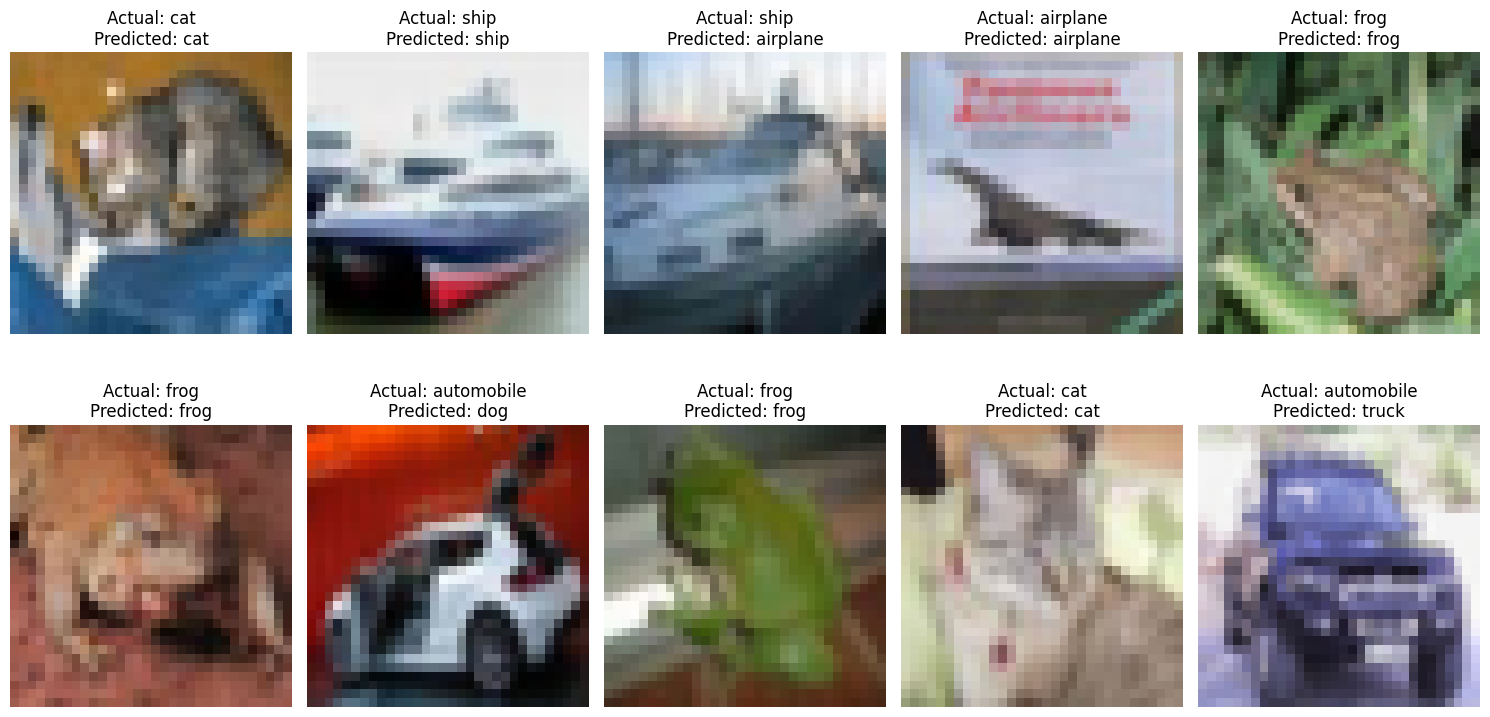

In [68]:
class_names = np.array([
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
])

# Function to plot images with their predicted and actual labels
def plot_images(images, labels_true, labels_pred, class_names, num_images=10):
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        title = f"Actual: {class_names[labels_true[i][0]]}\nPredicted: {class_names[labels_pred[i]]}"
        plt.title(title)
    plt.tight_layout()
    plt.show()

# Convert predictions from probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Plot some images along with their predicted and actual labels
plot_images(x_test, y_test, predicted_classes, class_names)